In [1]:
%matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.linalg import solve


Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:

# Параметры
eps = 0.01
h = 0.1  # шаг по времени
t_max = 1500
N = int(t_max / h)


In [3]:
def f(X):
    x, y, alpha = X
    dx = x * (1 - 0.5 * x - (2 / (7 * alpha**2)) * y)
    dy = y * (2 * alpha - 3.5 * alpha**2 * x - 0.5 * y)
    dalpha = eps * (2 - 7 * alpha * x)
    return np.array([dx, dy, dalpha])

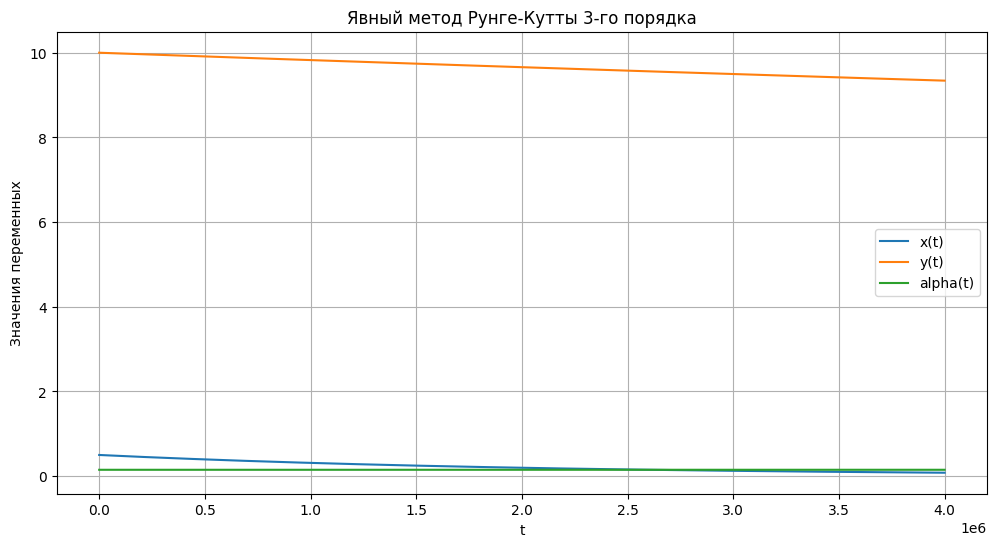

In [10]:

h = 0.000001
t_max = 4000000


x0, y0, alpha0 = 0.5, 10.0, 0.15

t = np.linspace(0, t_max, N+1)
X = np.zeros((N+1, 3))
X[0] = [x0, y0, alpha0]

# Реализация явного РК3
for n in range(N):
    Xn = X[n]
    k1 = f(Xn)
    k2 = f(Xn + h * k1 / 2)
    k3 = f(Xn - h * k1 + 2 * h * k2)
    X[n+1] = Xn + h * (k1 + 4 * k2 + k3) / 6

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(t, X[:, 0], label='x(t)')
plt.plot(t, X[:, 1], label='y(t)')
plt.plot(t, X[:, 2], label='alpha(t)')
plt.xlabel('t')
plt.ylabel('Значения переменных')
plt.title('Явный метод Рунге-Кутты 3-го порядка')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_22386/399779425.py:30: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  Z = fsolve(stage_residual, Z0)


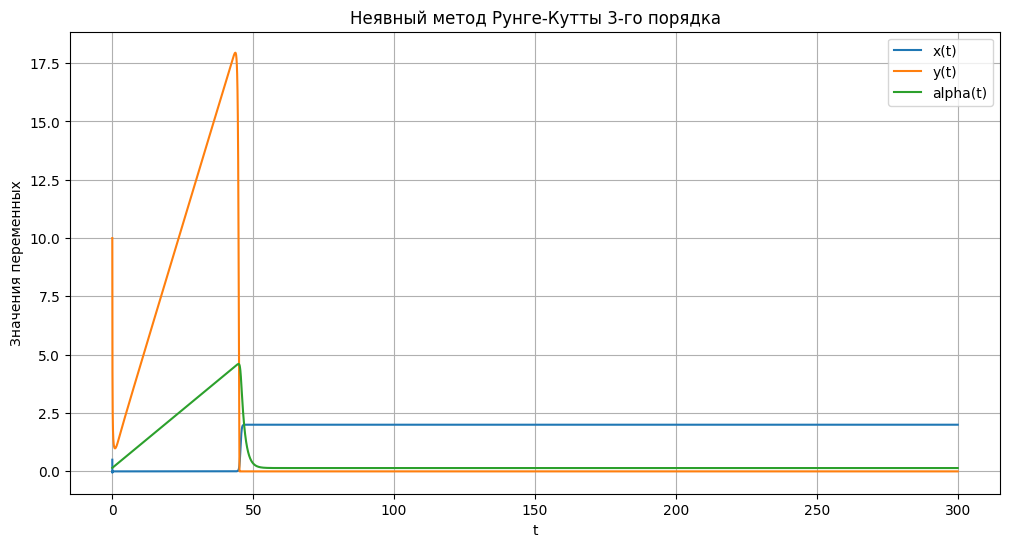

In [5]:

t_max = 300

h=0.1
x0, y0, alpha0 = 0.5, 10.0, 0.15


# Инициализация
t = np.linspace(0, t_max, N+1)
X = np.zeros((N+1, 3))
X[0] = [x0, y0, alpha0]


A = np.array([[5/12, -1/12],
              [3/4,   1/4]])
b = np.array([3/4, 1/4])
c = np.array([1/3, 1])


for n in range(N):
    Xn = X[n]

    def stage_residual(Z):
        Z1 = Z[:3]
        Z2 = Z[3:]
        F1 = f(Xn + h * (A[0, 0] * Z1 + A[0, 1] * Z2))
        F2 = f(Xn + h * (A[1, 0] * Z1 + A[1, 1] * Z2))
        return np.concatenate([Z1 - F1, Z2 - F2])

    Z0 = np.concatenate([f(Xn), f(Xn)])
    Z = fsolve(stage_residual, Z0)
    K1, K2 = Z[:3], Z[3:]

    X[n+1] = Xn + h * (b[0] * K1 + b[1] * K2)


plt.figure(figsize=(12, 6))
plt.plot(t, X[:, 0], label='x(t)')
plt.plot(t, X[:, 1], label='y(t)')
plt.plot(t, X[:, 2], label='alpha(t)')
plt.xlabel('t')
plt.ylabel('Значения переменных')
plt.title('Неявный метод Рунге-Кутты 3-го порядка')
plt.legend()
plt.grid(True)
plt.show()


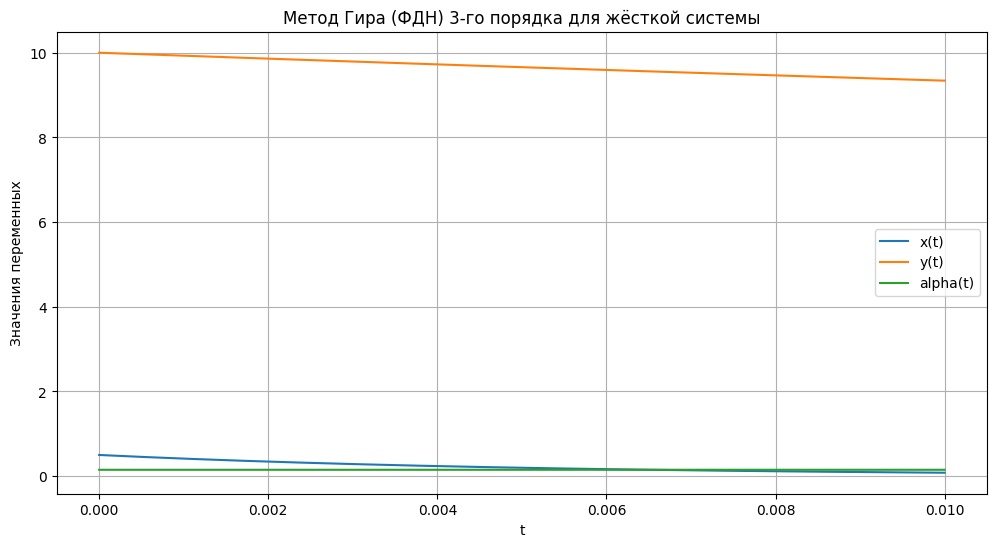

In [11]:

t_max = 0.01



x0, y0, alpha0 = 0.5, 10.0, 0.15



def rk4_step(F, X, h):
    k1 = F(X)
    k2 = F(X + h/2 * k1)
    k3 = F(X + h/2 * k2)
    k4 = F(X + h * k3)
    return X + h/6 * (k1 + 2*k2 + 2*k3 + k4)


t = np.linspace(0, t_max, N+1)
X = np.zeros((N+1, 3))
X[0] = [x0, y0, alpha0]
X[1] = rk4_step(f, X[0], h)
X[2] = rk4_step(f, X[1], h)

# Метод Гира 3-го порядка (неявная ФДН)
# Формула: X_{n+1} = (18*X_n - 9*X_{n-1} + 2*X_{n-2}) / 11 + (6h/11) * f(X_{n+1})

for n in range(2, N):
    Xn, Xn1, Xn2 = X[n], X[n-1], X[n-2]
    predictor = (18 * Xn - 9 * Xn1 + 2 * Xn2) / 11

    def residual(X_next):
        return X_next - predictor - (6 * h / 11) * f(X_next)


    X[n+1] = fsolve(residual, Xn)


plt.figure(figsize=(12, 6))
plt.plot(t, X[:, 0], label='x(t)')
plt.plot(t, X[:, 1], label='y(t)')
plt.plot(t, X[:, 2], label='alpha(t)')
plt.xlabel('t')
plt.ylabel('Значения переменных')
plt.title('Метод Гира (ФДН) 3-го порядка для жёсткой системы')
plt.legend()
plt.grid(True)
plt.show()


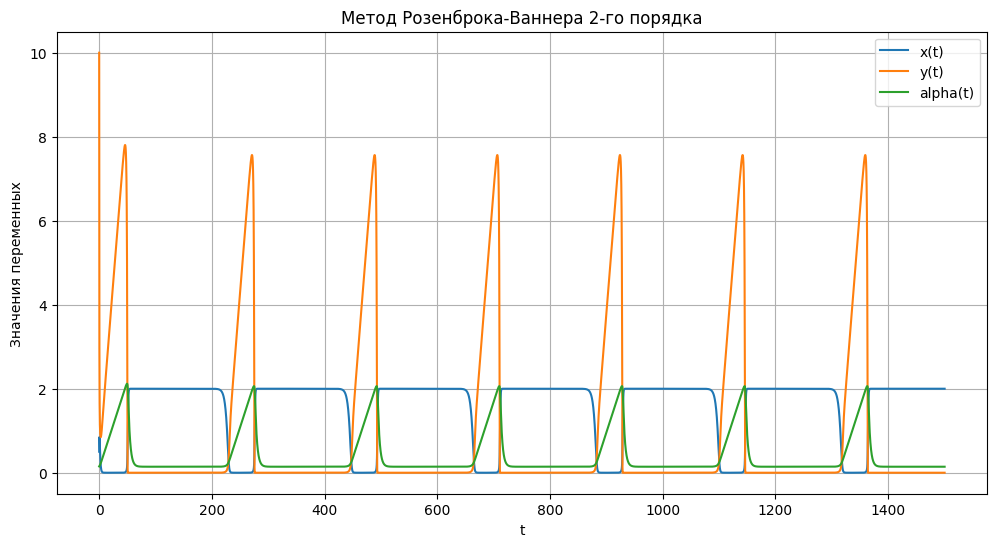

In [7]:

# Параметры системы
epsilon = 0.01
tau = 1.0  # Уточните значение τ из условия задачи!


# Якобиан системы
def system_jacobian(state):
    x, y, a = state
    J = np.zeros((3, 3))


    J[0, 0] = 1 - x - (2/(tau*a**2))*y
    J[0, 1] = - (2/(tau*a**2)) * x
    J[0, 2] = (4/(tau*a**3)) * x * y


    J[1, 0] = -3.5 * a**2 * y
    J[1, 1] = 2*a - 3.5*a**2*x - y
    J[1, 2] = 2*y - 7*a*x*y


    J[2, 0] = -epsilon * tau * a
    J[2, 1] = 0.0
    J[2, 2] = -epsilon * tau * x

    return J


def rosenbrock_step(state, h):
    gamma = 1.0 + np.sqrt(2)/2
    I = np.eye(3)
    fu = f(state)
    J = system_jacobian(state)


    A = I - gamma * h * J
    k1 = solve(A, h * fu)


    f_new = f(state + k1)


    b = h * (f_new + gamma * k1)
    k2 = solve(A, b)


    new_state = state + 1.5*k1 + 0.5*k2
    return new_state


def solve_system(x0, y0, a0, Tk, h=0.1):
    t = 0.0
    state = np.array([x0, y0, a0], dtype=np.float64)
    times = [t]
    states = [state.copy()]

    while t < Tk:
        state = rosenbrock_step(state, h)
        t += h
        times.append(t)
        states.append(state.copy())


        if state[2] < 1e-8:
            raise ValueError("a small!!!")

    return np.array(times), np.array(states)


x0, y0, a0 = 0.5, 10.0, 0.15

# Решение
t, X = solve_system(x0, y0, a0, 1500, h=0.1)


plt.figure(figsize=(12, 6))
plt.plot(t, X[:, 0], label='x(t)')
plt.plot(t, X[:, 1], label='y(t)')
plt.plot(t, X[:, 2], label='alpha(t)')
plt.xlabel('t')
plt.ylabel('Значения переменных')
plt.title('Метод Розенброка-Ваннера 2-го порядка')
plt.legend()
plt.grid(True)
plt.show()